<a href="https://colab.research.google.com/github/PlywoodWolf/NeuNet_study/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация отзывов на фильмы с помощью LSTM


1.   Для начала тексты нужно токенизировать - разбить на слова и присвоить каждому слову id
2.   Затем каждое слово (токен) нужно передать в эмбеддинговый слой, чтобы получить компактный вектор
3.   Эмбеддинги передаем на вход в рекуррентную сеть (LSTM)
4.   После обработки последнего слова отзыва делаем предсказание.

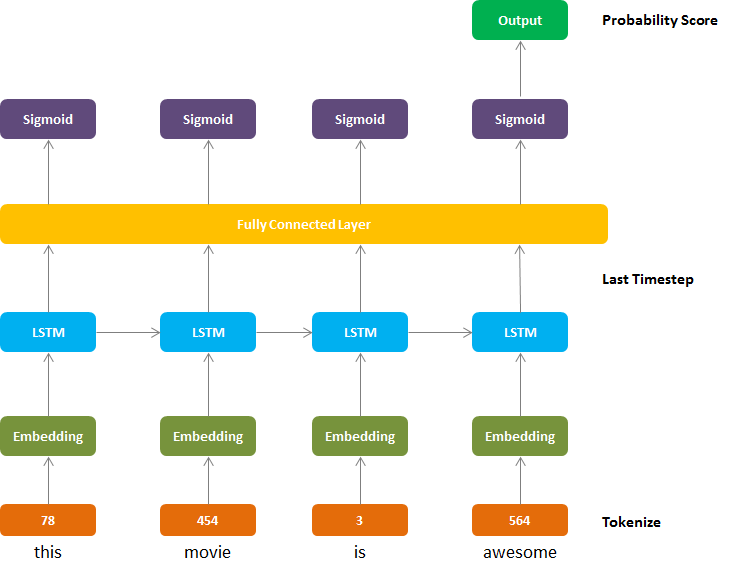

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

 20230221_7-519_Марков_Доклад_Физика.gdoc  'Апгрейд АРМ.gsheet'
 7-519					   'БД КР Clickhouse.gdoc'
 Arc					   'Копия labels.txt'
'Colab Notebooks'			   'Копия reviews.txt'
 flower-resnet.pth			    ПельмеНЬ
 flowers				   'Презентация ИСУ.gslides'
 HDD.gsheet				   'Проектное предложение.gslides'
 Kanbanchi				    Хлам
'Анализ проекта.gslides'


# Готовим данные

In [ ]:
import numpy as np
from string import punctuation
from collections import Counter
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tqdm import tqdm

import random
random.seed(33)
torch.manual_seed(0)

In [ ]:
# Считываем данные из файлов
with open('drive/MyDrive/reviews.txt', 'r') as f:
    reviews = f.read()
with open('drive/MyDrive/labels.txt', 'r') as f:
    labels = f.read()

In [ ]:
# Напечатаем первые 140 символов из файла с отзывами и 9 символов из файла с лейблами
print(reviews[:100])
print(labels[:9])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life
positive



In [ ]:
def preprocess(text):
    """"
    Функция чтобы разбить сплошной текст на отдельные отзывы, убрать пунктуацию
    и выделить все слова
    """
    text = "".join([s for s in text if s not in punctuation]) # убираем пунктуацию
    all_reviews = text.split("\n") # разделяем текст на ревью
    text = " ".join(all_reviews)
    all_words = text.split() # получаем массив слов

    return all_reviews, all_words


all_reviews, all_words = preprocess(reviews)
print('Общее число отзывов: ', len(all_reviews))

Общее число отзывов:  25001


In [ ]:
print('Первые 2 отзыва: ', all_reviews[:2])
print('Первые 5 слов: ', all_words[:5])

Первые 2 отзыва:  ['bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   ', 'story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned int

In [ ]:
corpus = Counter(all_words)
# Отсортируем слова по встречаемости
corpus_ = sorted(corpus,key=corpus.get,reverse=True)#[:1000]
print('Самые частые слова: ', corpus_[:10])
# кодируем каждое слово - присваиваем ему порядковый номер
vocab_to_int = {w:i+1 for i,w in enumerate(corpus_)}
print('Уникальных слов: ', len(vocab_to_int))

# Кодируем все отзывы: последовательность слов --> последовательность чисел
encoded_reviews = []
for sent in all_reviews:
  encoded_reviews.append([vocab_to_int[word] for word in sent.lower().split()
                                  if word in vocab_to_int.keys()])
print('Пример закодированного ревью: ', encoded_reviews[0])

Самые частые слова:  ['the', 'and', 'a', 'of', 'to', 'is', 'br', 'it', 'in', 'i']
Уникальных слов:  74072
Пример закодированного ревью:  [21025, 308, 6, 3, 1050, 207, 8, 2138, 32, 1, 171, 57, 15, 49, 81, 5785, 44, 382, 110, 140, 15, 5194, 60, 154, 9, 1, 4975, 5852, 475, 71, 5, 260, 12, 21025, 308, 13, 1978, 6, 74, 2395, 5, 613, 73, 6, 5194, 1, 24103, 5, 1983, 10166, 1, 5786, 1499, 36, 51, 66, 204, 145, 67, 1199, 5194, 19869, 1, 37442, 4, 1, 221, 883, 31, 2988, 71, 4, 1, 5787, 10, 686, 2, 67, 1499, 54, 10, 216, 1, 383, 9, 62, 3, 1406, 3686, 783, 5, 3483, 180, 1, 382, 10, 1212, 13583, 32, 308, 3, 349, 341, 2913, 10, 143, 127, 5, 7690, 30, 4, 129, 5194, 1406, 2326, 5, 21025, 308, 10, 528, 12, 109, 1448, 4, 60, 543, 102, 12, 21025, 308, 6, 227, 4146, 48, 3, 2211, 12, 8, 215, 23]


In [ ]:
all_labels = labels.split("\n")
encoded_labels = [1 if label == "positive" else 0 for label in all_labels]

print('Число отзывов и число лейблов: ', len(all_reviews), len(all_labels))

Число отзывов и число лейблов:  25001 25001


In [ ]:
encoded_labels = np.array( [label for idx, label in enumerate(encoded_labels) if len(encoded_reviews[idx]) > 0] )
encoded_reviews = [review for review in encoded_reviews if len(review) > 0]

print(len(encoded_labels), len(encoded_reviews))

25000 25000


Упакуем все последовательности, чтобы они имели одинаковую длину seq_len и могли быть организованы в тензоры по батчам

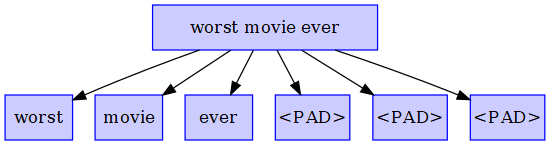

In [ ]:
def pad_text(encoded_reviews, seq_length):
    reviews = []
    for review in encoded_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(review)) + review)

    return np.array(reviews)


padded_reviews = pad_text(encoded_reviews, seq_length = 200)
print('Пример padded review: ', padded_reviews[0])

Пример padded review:  [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
 21025   308     6     3  1050   207     8  2138    32     1   171    57
    15    49    81  5785    44   382   110   140    15  5194    60   154
     9     1  4975  5852   475    71     5   260    12 21025   308    13
  1978     6    74  2395     5   613    73     6  5194     1 24103     5
  1983 10166     1  5786  1499    36    51    66   204   145    67  1199
  5194 19869     1 37442     4     1   221   883    31  2988    71     4
     1  5787    10   686     2    67  1499    54    10   216     1   383
     9    62     3  1406  3686   783     5  3483   180     1   382    10
  1212 13583    32   308    

In [ ]:
# dataset = TensorDataset(torch.from_numpy(padded_reviews), torch.from_numpy(encoded_labels))

train_set = TensorDataset(torch.from_numpy(padded_reviews[:20000]), torch.from_numpy(encoded_labels[:20000]))
val_set = TensorDataset(torch.from_numpy(padded_reviews[20000:]), torch.from_numpy(encoded_labels[20000:]))

In [ ]:
batch_size = 50

# train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-5000, 5000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  20000 5000


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Задаем модель

In [ ]:
class SentimentRNN(nn.Module):
    """
    Соберем модель для классификации текстов
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        """
        Инициализируем модель, обозначая слои и гиперпараметры
        """
        super(SentimentRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers = num_layers)

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x, h):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, h)
        lstm_out = lstm_out[:, -1, :] # getting the last time step output

        # fully-connected layer
        out = self.fc(lstm_out)
        # sigmoid function
        out = self.sig(out)
        # return last sigmoid output
        return out

# Задаем оптимизатор, гиперпараметры и функции для обучения

In [ ]:
vocab_size = len(vocab_to_int)+1
embedding_dim = 100
hidden_dim = 256
num_layers = 1
model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, num_layers)
model.to(device)

optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
lr = 0.001 # learning rate

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")

In [ ]:
def accuracy(outputs, labels):
    preds = torch.round(outputs.squeeze())
    # print(preds, labels)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def trainval(model, loaders, optimizer, epochs=5):
  """
  model: модель, которую собираемся обучать
  loaders: dict с dataloader'ами для обучения и валидации
  optimizer: оптимизатор
  epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
  """
  loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
  accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

  loss_track = {'training': [], 'validation': []}
  accuracy_track = {'training': [], 'validation': []}

  for epoch in range(epochs): # итерации по эпохам
      for mode in ['training', 'validation']: # обучение - валидация
          # считаем градиаент только при обучении:
          with torch.set_grad_enabled(mode == 'training'):
              # в зависимоти от фазы переводим модель в нужный ружим:
              model.train() if mode == 'training' else model.eval()
              for texts, labels in tqdm(loaders[mode]):
                  texts = texts.to(device) # отправляем тензор на GPU
                  labels = labels.to(device)
                  bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                  zero_init = torch.zeros(num_layers,bs,hidden_dim).to(device)
                  h = tuple([zero_init, zero_init])

                  preds = model(texts, h) # forward pass - прогоняем тензор с картинками через модель

                  loss = nn.BCELoss()(preds.squeeze(), labels.float())

                  loss_meter[mode].add(loss.item(), bs)

                  # если мы в фазе обучения
                  if mode == 'training':
                      optimizer.zero_grad() # обнуляем прошлый градиент
                      loss.backward() # делаем backward pass (считаем градиент)
                      optimizer.step() # обновляем веса

                  acc = accuracy(preds, labels) # считаем метрику
                  # храним loss и accuracy для батча
                  accuracy_meter[mode].add(acc, bs)

          # в конце фазы выводим значения loss и accuracy
          log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

          # сохраняем результаты по всем эпохам
          loss_track[mode].append(loss_meter[mode].value())
          accuracy_track[mode].append(accuracy_meter[mode].value())
  return loss_track, accuracy_track

In [ ]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=30)

100%|██████████| 400/400 [00:07<00:00, 56.41it/s]


[training] Epoch: 0.00. Loss: 0.67. Accuracy: 59.39% 


100%|██████████| 100/100 [00:00<00:00, 138.95it/s]


[validation] Epoch: 0.00. Loss: 0.65. Accuracy: 62.10% 


100%|██████████| 400/400 [00:07<00:00, 54.74it/s]


[training] Epoch: 1.00. Loss: 0.65. Accuracy: 61.85% 


100%|██████████| 100/100 [00:00<00:00, 140.10it/s]


[validation] Epoch: 1.00. Loss: 0.65. Accuracy: 62.26% 


100%|██████████| 400/400 [00:06<00:00, 58.51it/s]


[training] Epoch: 2.00. Loss: 0.61. Accuracy: 65.59% 


100%|██████████| 100/100 [00:00<00:00, 139.26it/s]


[validation] Epoch: 2.00. Loss: 0.61. Accuracy: 66.09% 


100%|██████████| 400/400 [00:07<00:00, 54.51it/s]


[training] Epoch: 3.00. Loss: 0.56. Accuracy: 69.89% 


100%|██████████| 100/100 [00:00<00:00, 139.46it/s]


[validation] Epoch: 3.00. Loss: 0.58. Accuracy: 69.13% 


100%|██████████| 400/400 [00:06<00:00, 58.24it/s]


[training] Epoch: 4.00. Loss: 0.50. Accuracy: 73.70% 


100%|██████████| 100/100 [00:00<00:00, 105.08it/s]


[validation] Epoch: 4.00. Loss: 0.55. Accuracy: 71.53% 


100%|██████████| 400/400 [00:07<00:00, 54.67it/s]


[training] Epoch: 5.00. Loss: 0.45. Accuracy: 76.87% 


100%|██████████| 100/100 [00:00<00:00, 137.73it/s]


[validation] Epoch: 5.00. Loss: 0.54. Accuracy: 73.04% 


100%|██████████| 400/400 [00:07<00:00, 55.36it/s]


[training] Epoch: 6.00. Loss: 0.41. Accuracy: 79.55% 


100%|██████████| 100/100 [00:01<00:00, 97.54it/s]


[validation] Epoch: 6.00. Loss: 0.54. Accuracy: 74.14% 


100%|██████████| 400/400 [00:07<00:00, 56.83it/s]


[training] Epoch: 7.00. Loss: 0.36. Accuracy: 81.78% 


100%|██████████| 100/100 [00:00<00:00, 134.70it/s]


[validation] Epoch: 7.00. Loss: 0.56. Accuracy: 74.84% 


100%|██████████| 400/400 [00:07<00:00, 53.51it/s]


[training] Epoch: 8.00. Loss: 0.33. Accuracy: 83.61% 


100%|██████████| 100/100 [00:00<00:00, 133.67it/s]


[validation] Epoch: 8.00. Loss: 0.57. Accuracy: 75.42% 


100%|██████████| 400/400 [00:07<00:00, 57.13it/s]


[training] Epoch: 9.00. Loss: 0.30. Accuracy: 85.17% 


100%|██████████| 100/100 [00:00<00:00, 138.54it/s]


[validation] Epoch: 9.00. Loss: 0.61. Accuracy: 75.81% 


100%|██████████| 400/400 [00:07<00:00, 53.69it/s]


[training] Epoch: 10.00. Loss: 0.27. Accuracy: 86.49% 


100%|██████████| 100/100 [00:00<00:00, 138.55it/s]


[validation] Epoch: 10.00. Loss: 0.63. Accuracy: 76.24% 


100%|██████████| 400/400 [00:07<00:00, 55.30it/s]


[training] Epoch: 11.00. Loss: 0.25. Accuracy: 87.59% 


100%|██████████| 100/100 [00:01<00:00, 96.60it/s]


[validation] Epoch: 11.00. Loss: 0.66. Accuracy: 76.48% 


100%|██████████| 400/400 [00:07<00:00, 55.86it/s]


[training] Epoch: 12.00. Loss: 0.23. Accuracy: 88.48% 


100%|██████████| 100/100 [00:00<00:00, 135.84it/s]


[validation] Epoch: 12.00. Loss: 0.70. Accuracy: 76.62% 


100%|██████████| 400/400 [00:07<00:00, 53.40it/s]


[training] Epoch: 13.00. Loss: 0.22. Accuracy: 89.29% 


100%|██████████| 100/100 [00:00<00:00, 136.46it/s]


[validation] Epoch: 13.00. Loss: 0.73. Accuracy: 76.87% 


100%|██████████| 400/400 [00:07<00:00, 56.64it/s]


[training] Epoch: 14.00. Loss: 0.20. Accuracy: 89.98% 


100%|██████████| 100/100 [00:00<00:00, 135.51it/s]


[validation] Epoch: 14.00. Loss: 0.76. Accuracy: 77.05% 


100%|██████████| 400/400 [00:07<00:00, 53.43it/s]


[training] Epoch: 15.00. Loss: 0.19. Accuracy: 90.59% 


100%|██████████| 100/100 [00:00<00:00, 135.81it/s]


[validation] Epoch: 15.00. Loss: 0.79. Accuracy: 77.27% 


100%|██████████| 400/400 [00:07<00:00, 55.71it/s]


[training] Epoch: 16.00. Loss: 0.18. Accuracy: 91.14% 


100%|██████████| 100/100 [00:01<00:00, 93.88it/s]


[validation] Epoch: 16.00. Loss: 0.82. Accuracy: 77.35% 


100%|██████████| 400/400 [00:07<00:00, 55.33it/s]


[training] Epoch: 17.00. Loss: 0.17. Accuracy: 91.63% 


100%|██████████| 100/100 [00:00<00:00, 132.41it/s]


[validation] Epoch: 17.00. Loss: 0.86. Accuracy: 77.45% 


100%|██████████| 400/400 [00:07<00:00, 53.47it/s]


[training] Epoch: 18.00. Loss: 0.16. Accuracy: 92.07% 


100%|██████████| 100/100 [00:00<00:00, 134.10it/s]


[validation] Epoch: 18.00. Loss: 0.89. Accuracy: 77.63% 


100%|██████████| 400/400 [00:07<00:00, 56.57it/s]


[training] Epoch: 19.00. Loss: 0.15. Accuracy: 92.46% 


100%|██████████| 100/100 [00:00<00:00, 135.99it/s]


[validation] Epoch: 19.00. Loss: 0.93. Accuracy: 77.75% 


100%|██████████| 400/400 [00:07<00:00, 52.60it/s]


[training] Epoch: 20.00. Loss: 0.15. Accuracy: 92.82% 


100%|██████████| 100/100 [00:00<00:00, 132.05it/s]


[validation] Epoch: 20.00. Loss: 0.97. Accuracy: 77.87% 


100%|██████████| 400/400 [00:07<00:00, 55.80it/s]


[training] Epoch: 21.00. Loss: 0.14. Accuracy: 93.15% 


100%|██████████| 100/100 [00:01<00:00, 95.73it/s]


[validation] Epoch: 21.00. Loss: 1.02. Accuracy: 77.98% 


100%|██████████| 400/400 [00:07<00:00, 54.51it/s]


[training] Epoch: 22.00. Loss: 0.13. Accuracy: 93.45% 


100%|██████████| 100/100 [00:00<00:00, 137.15it/s]


[validation] Epoch: 22.00. Loss: 1.06. Accuracy: 78.07% 


100%|██████████| 400/400 [00:07<00:00, 53.16it/s]


[training] Epoch: 23.00. Loss: 0.13. Accuracy: 93.72% 


100%|██████████| 100/100 [00:00<00:00, 133.91it/s]


[validation] Epoch: 23.00. Loss: 1.11. Accuracy: 78.17% 


100%|██████████| 400/400 [00:07<00:00, 56.20it/s]


[training] Epoch: 24.00. Loss: 0.12. Accuracy: 93.97% 


100%|██████████| 100/100 [00:00<00:00, 135.21it/s]


[validation] Epoch: 24.00. Loss: 1.16. Accuracy: 78.25% 


100%|██████████| 400/400 [00:07<00:00, 52.47it/s]


[training] Epoch: 25.00. Loss: 0.12. Accuracy: 94.20% 


100%|██████████| 100/100 [00:00<00:00, 132.35it/s]


[validation] Epoch: 25.00. Loss: 1.22. Accuracy: 78.32% 


100%|██████████| 400/400 [00:07<00:00, 55.39it/s]


[training] Epoch: 26.00. Loss: 0.11. Accuracy: 94.42% 


100%|██████████| 100/100 [00:01<00:00, 94.74it/s]


[validation] Epoch: 26.00. Loss: 1.27. Accuracy: 78.39% 


100%|██████████| 400/400 [00:07<00:00, 54.38it/s]


[training] Epoch: 27.00. Loss: 0.11. Accuracy: 94.62% 


100%|██████████| 100/100 [00:00<00:00, 132.68it/s]


[validation] Epoch: 27.00. Loss: 1.33. Accuracy: 78.45% 


100%|██████████| 400/400 [00:07<00:00, 53.17it/s]


[training] Epoch: 28.00. Loss: 0.11. Accuracy: 94.80% 


100%|██████████| 100/100 [00:00<00:00, 133.50it/s]


[validation] Epoch: 28.00. Loss: 1.38. Accuracy: 78.51% 


100%|██████████| 400/400 [00:07<00:00, 56.49it/s]


[training] Epoch: 29.00. Loss: 0.10. Accuracy: 94.98% 


100%|██████████| 100/100 [00:00<00:00, 132.73it/s]

[validation] Epoch: 29.00. Loss: 1.44. Accuracy: 78.56% 


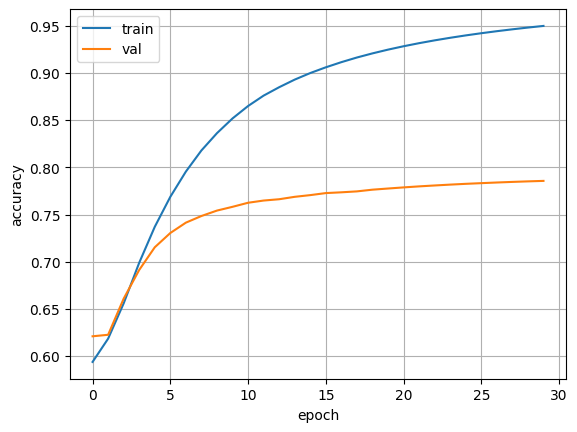

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='train')
plt.plot(accuracy_track['validation'], label='val')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

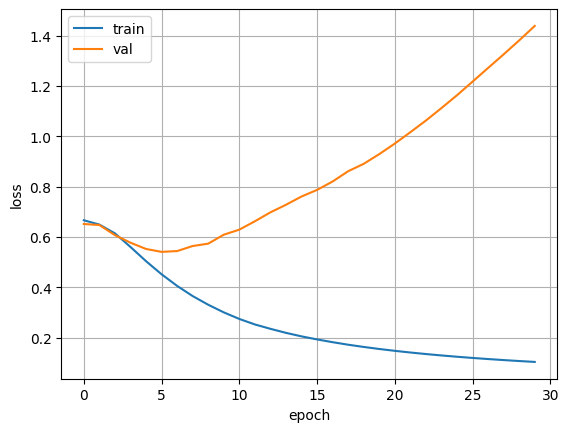

In [ ]:
plt.plot(loss_track['training'], label='train')
plt.plot(loss_track['validation'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend()

In [ ]:
def predict(model, review, seq_length = 200):
    print(review)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    _, words = preprocess(review.lower())
    encoded_words =  [vocab_to_int[word] for word in words if word in vocab_to_int.keys()]
    padded_words = pad_text([encoded_words], seq_length)
    padded_words = torch.from_numpy(padded_words).to(device)
    bs=1
    model.eval()
    zero_init = torch.zeros(num_layers,bs,hidden_dim).to(device)
    h = tuple([zero_init, zero_init])
    output = model(padded_words, h)
    pred = torch.round(output.squeeze())
    out = "This is a positive review." if pred == 1 else "This is a negative review."
    print(out, '\n')


review1 = "Twin Peaks is a very good film to watch with a family. Even five year old child will understand David Lynch masterpiece"
review2 = "It made me cry"
review3 = "It made me cry - I never seen such an awful acting before"
review4 = "Vulgarity. Ringing vulgarity"
review5 = "Garbage"

predict(model, review1)
predict(model, review2)
predict(model, review3)
predict(model, review4)
predict(model, review5)

Twin Peaks is a very good film to watch with a family. Even five year old child will understand David Lynch masterpiece
This is a positive review. 

It made me cry
This is a positive review. 

It made me cry - I never seen such an awful acting before
This is a negative review. 

Vulgarity. Ringing vulgarity
This is a positive review. 

Garbage
This is a negative review. 

